In [6]:
!nvidia-smi

Wed Jan 18 12:49:40 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.00       Driver Version: 517.00       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   49C    P8     3W /  N/A |      0MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
import sys
# home_folder = r'/zhome/60/1/118435/Master_Thesis/GoalCornerDetection'
home_folder = 'C:\\Users\\Nikolaj\\OneDrive - Danmarks Tekniske Universitet\\DTU\\Kandidat\\MasterThesis\\Code\\GoalCornerDetection'
sys.path.append(home_folder)

In [8]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "0,1"
import torch
import numpy as np
import matplotlib.pyplot as plt
from Core.helpers import to_torch,to_numpy,split_data_train_test,im_to_numpy
from Core.DataLoader import GoalCalibrationDataset,GoalCalibrationDataset4boxes
from Core.plottools import target_to_keypoints,batch_target_to_keypoints,plot_batch_keypoints,visualize, \
visualize_results, make_GT_image
from utils import DATA_DIR
from tqdm.notebook import tqdm
from sklearn.cluster import KMeans
import pickle
from torchvision.models.detection.rpn import AnchorGenerator

In [9]:
GoalData = GoalCalibrationDataset(DATA_DIR)
GoalData4box = GoalCalibrationDataset4boxes(DATA_DIR)
train_loader,validation_loader = split_data_train_test(
                                                        GoalData4box,
                                                        GoalData4box,
                                                        validation_split=0.25,
                                                        batch_size=2,
                                                        data_amount=0.1,
                                                        num_workers=0,
                                                        shuffle_dataset=False,
                                                        shuffle_dataset_seed=-1,
                                                        shuffle_epoch = False,
                                                        shuffle_epoch_seed=-1,
                                                        pin_memory=False)

All images: 854
Filtered images: 754
All images: 854
Filtered images: 754
Config not given, using default values for bbox_expand.
###################
Total size of dataset: 75
Train data --> Size: 57, batch size: 2
Validation data --> Size: 18, batch size: 2


In [135]:
anchor_sizes = ((64,), (128,), (256,), (384,), (512,))
aspect_ratios_all = (4208/3120, 1.0, 2.0, 2.5, 3.0, 0.5, 4.0)
aspect_ratios_anchors = (aspect_ratios_all[:3], ) #* len(anchor_sizes)
print(aspect_ratios_anchors)
# ag = AnchorGenerator(sizes=anchor_sizes, aspect_ratios=aspect_ratios_anchors)
ag = AnchorGenerator(sizes=(32,64,128,256,512),aspect_ratios=((0.5, 1.0, 2.0),))

((1.3487179487179488, 1.0, 2.0),)


In [136]:
anchors = ag.generate_anchors(ag.sizes,ag.aspect_ratios)
print(anchors.shape)
print(anchors)
anchor_dims = torch.stack((anchors[:,0]-anchors[:,2], anchors[:,1]-anchors[:,3]),axis=1) 
print(anchor_dims)
print(np.sqrt(anchor_dims[:,0]*anchor_dims[:,1]))

torch.Size([15, 4])
tensor([[ -23.,  -11.,   23.,   11.],
        [ -16.,  -16.,   16.,   16.],
        [ -11.,  -23.,   11.,   23.],
        [ -45.,  -23.,   45.,   23.],
        [ -32.,  -32.,   32.,   32.],
        [ -23.,  -45.,   23.,   45.],
        [ -91.,  -45.,   91.,   45.],
        [ -64.,  -64.,   64.,   64.],
        [ -45.,  -91.,   45.,   91.],
        [-181.,  -91.,  181.,   91.],
        [-128., -128.,  128.,  128.],
        [ -91., -181.,   91.,  181.],
        [-362., -181.,  362.,  181.],
        [-256., -256.,  256.,  256.],
        [-181., -362.,  181.,  362.]])
tensor([[ -46.,  -22.],
        [ -32.,  -32.],
        [ -22.,  -46.],
        [ -90.,  -46.],
        [ -64.,  -64.],
        [ -46.,  -90.],
        [-182.,  -90.],
        [-128., -128.],
        [ -90., -182.],
        [-362., -182.],
        [-256., -256.],
        [-182., -362.],
        [-724., -362.],
        [-512., -512.],
        [-362., -724.]])
tensor([ 31.8119,  32.0000,  31.8119,  64.3428, 

In [116]:
print(ag.sizes)
print(ag.aspect_ratios)

((128, 256, 512),)
((0.5, 1.0, 2.0),)


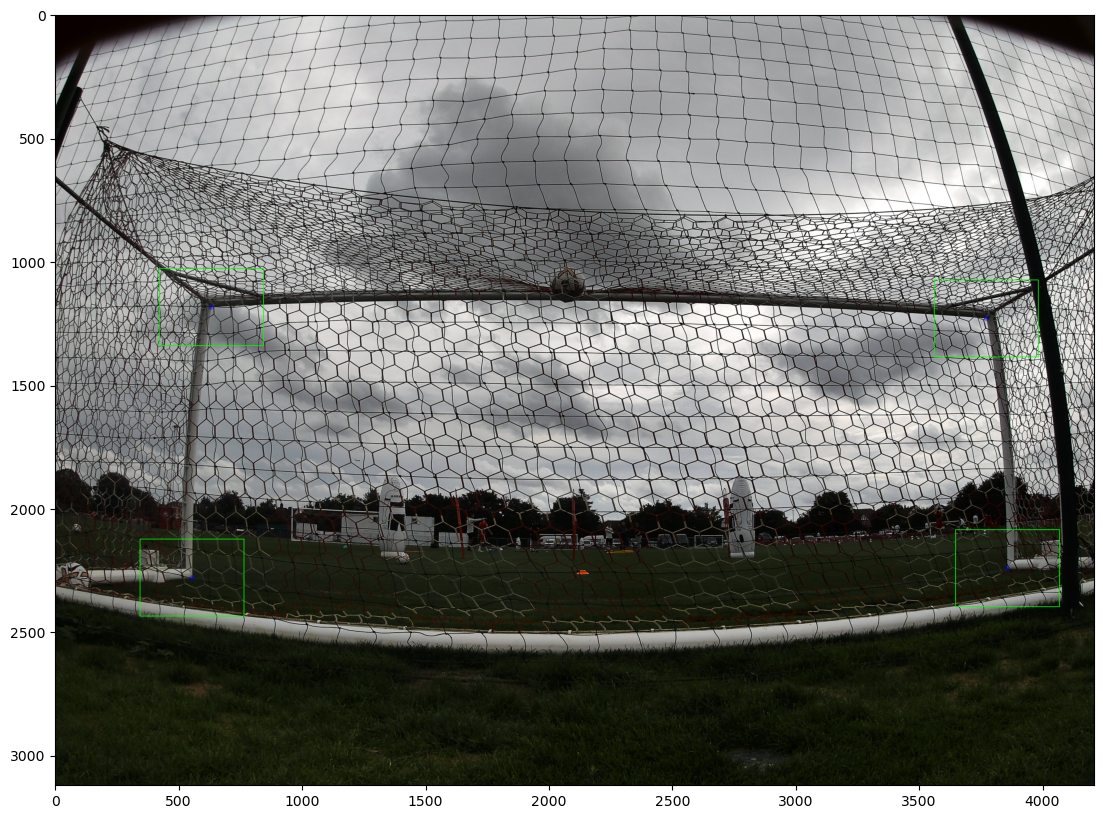

In [8]:
images,targets = next(iter(validation_loader))
image_og = images[0]
# image = (im_to_numpy(images[0]) * 255).astype(np.uint8)
bboxes_og = targets[0]['boxes']
keypoints_og = targets[0]['keypoints']
# bboxes = [list(map(int, bbox.tolist())) for bbox in to_numpy(targets[0]['boxes'])]
# keypoints = [[list(map(int, kp[:2])) for kp in kps] for kps in to_numpy(targets[0]['keypoints'])]
visualize(image_og, bboxes_og, keypoints_og)

In [ ]:
keypoints_classes_ids2names = {0: 'top-left', 1: 'top-right', 2: 'bot-left', 3: 'bot-right'}

    for bbox in bboxes:
        start_point = (bbox[0], bbox[1])
        end_point = (bbox[2], bbox[3])
        image = cv2.rectangle(image.copy(), start_point, end_point, (0,255,0), 2)
    
    for kps in keypoints:
        for idx, kp in enumerate(kps):
            image = cv2.circle(image.copy(), tuple(kp), 5, (255,0,0), 10)
            image = cv2.putText(image.copy(), " " + keypoints_classes_ids2names[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

    if image_original is None and keypoints_original is None:
        plt.figure(figsize=(20,10))
        plt.imshow(image)

    else:
        for bbox in bboxes_original:
            start_point = (bbox[0], bbox[1])
            end_point = (bbox[2], bbox[3])
            image_original = cv2.rectangle(image_original.copy(), start_point, end_point, (0,255,0), 2)

        keypoints_classes_ids2names_original= {0: 'top-left', 1: 'top-right', 2: 'bot-left', 3: 'bot-right'}
        for kps in keypoints_original:
            for idx, kp in enumerate(kps):
                image_original = cv2.circle(image_original, tuple(kp), 5, (255,0,0), 10)
                image_original = cv2.putText(image_original, " " + keypoints_classes_ids2names_original[idx], tuple(kp), cv2.FONT_HERSHEY_SIMPLEX, 2, (255,0,0), 3, cv2.LINE_AA)

        f, ax = plt.subplots(1, 2, figsize=(40, 40))

        ax[0].imshow(image_original)
        ax[0].set_title(title_old, fontsize=fontsize)

        ax[1].imshow(image)
        ax[1].set_title(f'{title_new}, Prediction confidence: {pred_score:.4f}', fontsize=fontsize)

In [36]:
image_ids = []
widths = []
heights = []

for _, target in tqdm(GoalData):
    image_ids.append(target['image_id'].item())
    tbox = target['boxes'][0].numpy()
    widths.append(tbox[2]-tbox[0])
    heights.append(tbox[3]-tbox[1])

  0%|          | 0/754 [00:00<?, ?it/s]

In [10]:
from pathlib import Path
with open(str(Path(home_folder+'/Tests/saved_data/widths.list')), 'rb') as f:
    widths = np.array(pickle.load(f))
with open(str(Path(home_folder+'/Tests/saved_data/heights.list')), 'rb') as f:
    heights = np.array(pickle.load(f))


best fit line:
y = 308.45 + 0.32x


Text(0.5, 0, 'width')

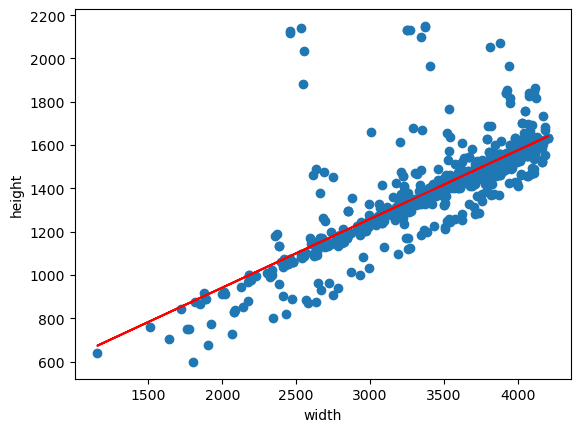

In [11]:
# solve for a and b
def best_fit(X, Y):

    xbar = sum(X)/len(X)
    ybar = sum(Y)/len(Y)
    n = len(X) # or len(Y)

    numer = sum([xi*yi for xi,yi in zip(X, Y)]) - n * xbar * ybar
    denum = sum([xi**2 for xi in X]) - n * xbar**2

    b = numer / denum
    a = ybar - b * xbar

    print('best fit line:\ny = {:.2f} + {:.2f}x'.format(a, b))

    return a, b

# solution
X = widths
Y = heights
a, b = best_fit(X, Y)
#best fit line:
#y = 735.90 + 1.92x
# y = 308.45 + 0.32x

# plot points and fit line
import matplotlib.pyplot as plt
plt.scatter(X, Y)
yfit = [a + b * xi for xi in X]
plt.plot(X, yfit, 'r')
plt.ylabel(f'height')
plt.xlabel(f'width')


In [13]:
# data = np.stack((widths,heights),axis=1)
# data.shape
aspect_ratios = widths/heights
sizes = np.sqrt(widths*heights)
print(f'aspect_ratios\nmin: {aspect_ratios.min()}, max: {aspect_ratios.max()}, mean: {aspect_ratios.mean()}')
print(f'sizes\nmin: {sizes.min()}, max: {sizes.max()}, mean: {sizes.mean()}')
data = np.stack((aspect_ratios,sizes),axis=1)
print(data.shape)
K = KMeans(3,)
print(f'Kmeans aspect_ratios:\n{K.fit(aspect_ratios[:,None]).cluster_centers_}')
print(f'Kmeans sizes:\n{K.fit(sizes[:,None]).cluster_centers_}')
print(f'Kmeans both:\n{K.fit(data).cluster_centers_}')

aspect_ratios
min: 1.1554450988769531, max: 3.0291340351104736, mean: 2.4632856845855713
sizes
min: 859.5225219726562, max: 2836.016357421875, mean: 2172.65625
(754, 2)
Kmeans aspect_ratios:
[[2.6424508]
 [2.415018 ]
 [1.7328656]]
Kmeans sizes:
[[2448.814 ]
 [1608.6725]
 [2110.914 ]]
Kmeans both:
[[2.4851558e+00 2.4488140e+03]
 [2.4688311e+00 2.1109141e+03]
 [2.3951023e+00 1.6086725e+03]]


Aspect Ratios: [0.4033609  0.4179339  0.42237374 0.41529807 0.40813908]
Scales: [2358.5999 1781.8329 1344.2156 2565.3494 2119.6553]


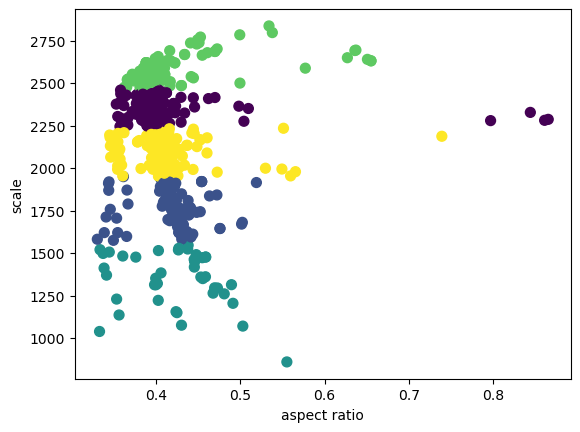

In [140]:
K = KMeans(5,)
clustering = K.fit(data)
plt.scatter(data[:, 0], data[:, 1], c=clustering.labels_, s=50, cmap='viridis')
plt.xlabel('aspect ratio')
plt.ylabel('scale')

out = clustering.cluster_centers_
ar = out[:,0]
scale = out[:,1]
print("Aspect Ratios: {}".format(ar))
print("Scales: {}".format(scale))

In [51]:
aspect_ratios[:,None].shape

(754, 1)

In [69]:
K = KMeans(10,)
clustering = K.fit(aspect_ratios[:,None])

In [70]:
K.cluster_centers_

array([[2.587867 ],
       [1.9237082],
       [2.4970708],
       [1.2217454],
       [2.331478 ],
       [2.7793493],
       [2.1893494],
       [2.423049 ],
       [1.5799502],
       [2.9273188]], dtype=float32)

In [61]:
print(f'ar -> min: {aspect_ratios.min()}, max: {aspect_ratios.max()}, mean: {aspect_ratios.mean()}, median: {np.median(aspect_ratios)}')

ar -> min: 1.1554450988769531, max: 3.0291340351104736, mean: 2.4632856845855713, median: 2.4849796295166016


Aspect Ratios: [2.4995015 2.527636  2.339924  2.2922437 2.4491165]
Scales: [9.214179 9.917332 5.193832 7.046959 8.323299]


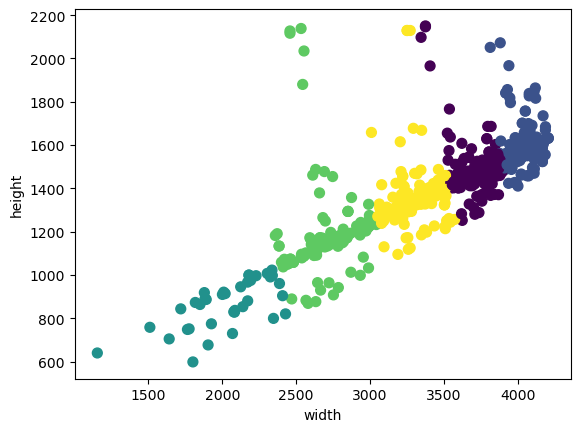

In [10]:
K = KMeans(5,)
clustering = K.fit(data)
plt.scatter(data[:, 0], data[:, 1], c=clustering.labels_, s=50, cmap='viridis')
plt.xlabel('width')
plt.ylabel('height')

out = clustering.cluster_centers_

ar = out[:,0] / out[:,1]
scale = out[:,1] * np.sqrt(ar) / 256
# sizes = [np.mean(cluster) for cluster in ]

print("Aspect Ratios: {}".format(ar))

print("Scales: {}".format(scale))


In [19]:
clustering.cluster_centers_
clustering.labels_

array([4, 4, 4, 0, 1, 2, 0, 4, 1, 3, 1, 3, 4, 4, 3, 4, 1, 2, 3, 1, 4, 3,
       0, 0, 1, 2, 4, 0, 3, 4, 0, 1, 0, 3, 3, 1, 3, 3, 3, 1, 1, 3, 4, 4,
       0, 3, 1, 4, 1, 4, 1, 0, 0, 4, 1, 2, 4, 0, 0, 2, 3, 0, 1, 1, 4, 4,
       0, 4, 3, 1, 4, 3, 0, 2, 0, 4, 1, 0, 4, 0, 4, 3, 4, 0, 0, 0, 2, 1,
       0, 4, 0, 1, 4, 4, 1, 0, 3, 1, 1, 4, 4, 3, 0, 0, 2, 0, 4, 3, 2, 0,
       4, 3, 0, 0, 4, 1, 4, 4, 1, 1, 2, 4, 1, 1, 0, 4, 0, 1, 1, 1, 4, 4,
       4, 1, 0, 4, 2, 0, 0, 4, 4, 3, 4, 0, 3, 4, 4, 1, 4, 1, 1, 1, 0, 0,
       0, 1, 0, 0, 4, 4, 2, 4, 2, 0, 4, 3, 1, 1, 0, 4, 4, 3, 1, 1, 3, 0,
       4, 0, 1, 3, 3, 1, 0, 0, 1, 4, 4, 4, 0, 4, 1, 3, 4, 0, 0, 0, 2, 4,
       3, 4, 4, 0, 4, 3, 3, 4, 3, 3, 3, 0, 1, 3, 4, 3, 0, 4, 1, 0, 3, 1,
       1, 4, 0, 3, 0, 0, 1, 4, 0, 3, 0, 3, 0, 4, 4, 3, 0, 4, 1, 1, 3, 3,
       1, 0, 3, 4, 4, 0, 2, 1, 4, 0, 4, 0, 2, 2, 1, 0, 0, 4, 0, 3, 0, 4,
       4, 4, 4, 3, 3, 0, 1, 2, 4, 4, 4, 0, 2, 1, 1, 3, 3, 3, 1, 3, 0, 0,
       3, 1, 1, 0, 0, 3, 3, 3, 3, 4, 0, 1, 4, 4, 1,

### RANDOM TEST

In [84]:

img,target = GoalData.__getitem__(0)
print(img.shape)
img = im_to_numpy(img)
print(img.shape)
kps = target['keypoints']
keypoints_original = to_numpy(kps.squeeze()[:,:2]).tolist()
print(f'keypoints_original:\n{keypoints_original}')
expand_x = 0.05 # expand boxes by this percentage (in decimal)
expand_y = 0.05
boxes_topleft_expand = keypoints_original - np.array([img.shape[1]*expand_x,img.shape[0]*expand_y])
boxes_topleft_keepinIm = np.array([[val if val > 0 else 1 for val in point] for point in boxes_topleft_expand])
# boxes_topleft_expand
print(f'boxes top left')
print(boxes_topleft_expand, f'shape: {boxes_topleft_expand.shape}')
print(boxes_topleft_keepinIm)
boxes_botright_expand = keypoints_original + np.array([img.shape[1]*expand_x,img.shape[0]*expand_y])
# shapeperm = np.transpose(img,axes=(1,0,2)).shape
maxsizes = (img.shape[1],img.shape[0])
boxes_botright_keepinIm = np.array([[val if val <= maxsizes[i] else maxsizes[i]-1 for i,val in enumerate(point)] for point in boxes_botright_expand])
print(f'boxes bot right')
print(boxes_botright_expand, f'shape: {boxes_botright_expand.shape}')
print(boxes_botright_keepinIm)
# boxes_botright_expand

bboxes = np.concatenate((box_topleft_keepinIm,box_botright_keepinIm),axis=1)
print(f'boxes:\n{bboxes}', f'shape: {bboxes.shape}')
bboxes = torch.tensor(bboxes)
bboxes.shape

torch.Size([3, 3120, 4208])
(3120, 4208, 3)
keypoints_original:
[[633.8738403320312, 1183.3262939453125], [3772.06787109375, 1229.333984375], [555.0842895507812, 2279.92626953125], [3857.657958984375, 2241.53515625]]
boxes top left
[[ 423.47384033 1027.32629395]
 [3561.66787109 1073.33398438]
 [ 344.68428955 2123.92626953]
 [3647.25795898 2085.53515625]] shape: (4, 2)
[[ 423.47384033 1027.32629395]
 [3561.66787109 1073.33398438]
 [ 344.68428955 2123.92626953]
 [3647.25795898 2085.53515625]]
boxes bot right
[[ 844.27384033 1339.32629395]
 [3982.46787109 1385.33398438]
 [ 765.48428955 2435.92626953]
 [4068.05795898 2397.53515625]] shape: (4, 2)
[[ 844.27384033 1339.32629395]
 [3982.46787109 1385.33398438]
 [ 765.48428955 2435.92626953]
 [4068.05795898 2397.53515625]]
boxes:
[[ 423.47384033 1027.32629395  844.27384033 1339.32629395]
 [3561.66787109 1073.33398438 3982.46787109 1385.33398438]
 [ 344.68428955 2123.92626953  765.48428955 2435.92626953]
 [3647.25795898 2085.53515625 4068.05795

torch.Size([4, 4])

In [58]:
import cv2
cv2.imread(GoalData.img_list[0]).shape

(3120, 4208, 3)

In [90]:
np.array(keypoints_original)[:,None,:].shape

(4, 1, 2)

In [96]:
(bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])

tensor([131289.6000, 131289.6000, 131289.6000, 131289.6000],
       dtype=torch.float64)